<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/sentimentos/notebook_gpt_async_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
!nvidia-smi

Sun Nov 19 17:27:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.02              Driver Version: 545.29.02    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off | 00000000:08:00.0  On |                  N/A |
|  0%   40C    P8              19W / 285W |  11199MiB / 12282MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [2]:
date = '2023-09-01'
filename = 'analisar.csv'
dados = pd.read_csv(f"/content/gdrive/MyDrive/tcc/exploratoria/{date}-{filename}")

dados.head()[['text', 'source', 'data_avaliacao']]

,text,source,data_avaliacao
0,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,2023-07-06
1,Tudo perfeito,hotel-marsol-beach-resort,2023-07-06
2,excelente!,hotel-marsol-beach-resort,2023-07-06
3,Belo lugar.,hotel-marsol-beach-resort,2023-07-06
4,Ótimo local,hotel-marsol-beach-resort,2023-07-06


In [3]:
treinado = pd.read_csv(f"/content/gdrive/MyDrive/tcc/testando-classificacao.csv")

treinado.head()[['text', 'source', 'data_avaliacao']]

,text,source,data_avaliacao
0,"Lugar fantástico, recomendo super.",analisar,2023-07-06
1,Tudo perfeito,analisar,2023-07-06
2,excelente!,analisar,2023-07-06
3,Belo lugar.,analisar,2023-07-06
4,Ótimo local,analisar,2023-07-06


In [4]:
dados.describe()

,rating,likes,mes_avaliacao,ano_avaliacao
count,49219.000000,49219.000000,49219.000000,49219.000000
mean,4.604787,0.166623,6.790650,2020.699181
std,0.895289,0.731727,1.524495,1.746374
min,1.000000,0.000000,1.000000,2018.000000
25%,5.000000,0.000000,7.000000,2019.000000
50%,5.000000,0.000000,7.000000,2021.000000
75%,5.000000,0.000000,7.000000,2022.000000
max,5.000000,25.000000,12.000000,2023.000000


In [51]:
!pip install openai

In [16]:
import os
import openai
openai.organization = os.environ["openai-organization"]
openai.base_url = "http://text-generation-webui:5000/v1/"
# ORGANIZATION
openai.api_key = os.environ["openai-apikey"]
# APIKEY

In [97]:
# {
#   "id": "chatcmpl-86pPcCAFqXeHV40fKVRmKYLzdqeWu",
#   "object": "chat.completion",
#   "created": 1696638288,
#   "model": "gpt-3.5-turbo-0613",
#   "choices": [
#     {
#       "index": 0,
#       "message": {
#         "role": "assistant",
#         "content": "-1"
#       },
#       "finish_reason": "stop"
#     }
#   ],
#   "usage": {
#     "prompt_tokens": 153,
#     "completion_tokens": 2,
#     "total_tokens": 155
#   }
# }
model = "TheBloke_vicuna-13B-v1.5-GPTQ"
prompt = """para você foi atribuida a tarefa de classificar o sentimento de sentenças em português que são avaliações de hoteis, classifique-as em 2, 1 e 0 sem necessidade de justificativa, levando em consideração que positivo é 2, neutro é 1, e negativo é 0
classifique a sentença abaixo:
[COMMENT]
"""

In [114]:
completion = openai.chat.completions.create(
  model=model,
  messages=[
    {"role": "user", "content": """para você foi atribuida a tarefa de classificar o sentimento de sentenças em português que são avaliações de hoteis, classifique-as em 2, 1 e 0 sem necessidade de justificativa, levando em consideração que positivo é 2, neutro é 1, e negativo é 0
classifique a sentença abaixo:
Foi muito bom."""}
  ],
  temperature=0.01,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

completion

ChatCompletion(id='chatcmpl-1700426563009649408', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='2', role='assistant', function_call=None, tool_calls=None))], created=1700426563, model='TheBloke_vicuna-13B-v1.5-GPTQ', object='chat.completions', system_fingerprint=None, usage=CompletionUsage(completion_tokens=3, prompt_tokens=138, total_tokens=141))

In [79]:
sentiments = ["negative", "neutral", "positive", "INVALID"]
# sentiments[int(completion["choices"][0]["message"]["content"])], completion["usage"]["total_tokens"]

In [80]:
import logging
import sys

logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

logger = logging.getLogger(__name__)

In [81]:
logger.error("oi")

ERROR:__main__:oi


In [122]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
    before_sleep_log
)  # for exponential backoff

@retry(wait=wait_random_exponential(multiplier= 2, min=30, max=600), stop=stop_after_attempt(30),
           before_sleep=before_sleep_log(logger, logging.ERROR))
def get_sentiment(content, model):
    result = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": content}],
        temperature=0.01,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        )
    print(result)
    response_sentiment = result.choices[0].message.content
    try:
      sentiment_int = int(response_sentiment)
    except:
      logger.error(content)
      logger.error(response_sentiment)
      sentiment_int = 3
    return sentiment_int, result.usage.total_tokens

In [127]:
# @title Texto de título padrão
comment = 'Foi muito bom'

# Get sentiment
comment_prompt = prompt.replace("[COMMENT]", comment)
result = get_sentiment(comment_prompt, model)
result

ChatCompletion(id='chatcmpl-1700426615777761536', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='2', role='assistant', function_call=None, tool_calls=None))], created=1700426615, model='TheBloke_vicuna-13B-v1.5-GPTQ', object='chat.completions', system_fingerprint=None, usage=CompletionUsage(completion_tokens=3, prompt_tokens=137, total_tokens=140))


(2, 140)

In [ ]:
dados.shape[0]

49219

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00


In [ ]:
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

text = "This is an example sentence to count tokens."
token_count = len(encoding.encode("".join(list(map(lambda x: prompt.replace("[COMMENT]", x),list(dados['text']))))))
print(f"The text contains {token_count} tokens.")

The text contains 6357835 tokens.


In [ ]:
token_count/1000 * 0.0015 + dados.shape[0]/1000 * 0.002 # custo

9.6351905

In [ ]:
dados.shape[0]/1000 * 0.002

0.098438

In [ ]:
!pip install multiprocess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 53.1 MB/s eta 0:00:00


In [ ]:
teste_sample = dados.sample(1)

def dataset_sentiment(row):
  # Init
  index = row[0]
  comment = row[1].text

  # Get sentiment
  comment_prompt = prompt.replace("[COMMENT]", comment)
  sentiment, consumed_tokens = get_sentiment(comment_prompt, model)

  row[1]['sentimento_gpt'] = sentiments[sentiment]
  row[1]['resultado_gpt'] = sentiment
  row[1]['tokens'] = consumed_tokens
  return row

In [ ]:
get_sentiment.retry

<Retrying object at 0x7f0619800700 (stop=<tenacity.stop.stop_after_attempt object at 0x7f0619802f80>, wait=<tenacity.wait.wait_random_exponential object at 0x7f0619800d60>, sleep=<function sleep at 0x7f061a8ea440>, retry=<tenacity.retry.retry_if_exception_type object at 0x7f061a91e8f0>, before=<function before_nothing at 0x7f061a924310>, after=<function after_nothing at 0x7f061a925000>)>

In [ ]:
dados.iloc[16264]

retrieval_date                                2023-07-07 00:38:21.052776
rating                                                               5.0
relative_date                                            3 semanas atrás
likes                                                                  0
user_is_local_guide                                                False
text                   Local limpo e linda parabéns. Lugar lindo enfr...
source                                          hotel-vila-galé---touros
user_reviews                                                           8
data_avaliacao                                                2023-06-16
mes_avaliacao                                                          6
ano_avaliacao                                                       2023
mes_ano_avaliacao                                                2023-06
com_texto                                                           True
nao_vazio                                          

In [ ]:
from multiprocess import Pool
from tqdm import tqdm
max_pool = 12

In [ ]:
with Pool(processes=max_pool) as pool:
  results = list(tqdm(pool.imap(dataset_sentiment, teste_sample.iterrows()), total=teste_sample.shape[0]))
  index_list, response_list = zip(*results)
  teste_sample = pd.DataFrame(response_list, index_list)

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


In [ ]:
with Pool(processes=max_pool) as pool:
  results = list(tqdm(pool.imap(dataset_sentiment, dados.iterrows()), total=dados.shape[0]))
  index_list, response_list = zip(*results)
  dados = pd.DataFrame(response_list, index_list)

A saída de streaming foi truncada nas últimas 5000 linhas.
ERROR:__main__:para você foi atribuida a tarefa de classificar o sentimento de sentenças em português que são avaliações de hoteis, classifique-as em 2, 1 e 0 sem necessidade de justificativa, levando em consideração que positivo é 2, neutro é 1, e negativo é 0
classifique a sentença abaixo:
Resort recém inaugurado de uma rede portuguesa de hoteis,

ERROR:__main__:para você foi atribuida a tarefa de classificar o sentimento de sentenças em português que são avaliações de hoteis, classifique-as em 2, 1 e 0 sem necessidade de justificativa, levando em consideração que positivo é 2, neutro é 1, e negativo é 0
classifique a sentença abaixo:
É muito longe,mas o hotel é bom.Tem uma grande estrutura e uma grande diversidade de comida. Crustáceos e peixes de qualidades são exemplos,porém os funcionários são muito despreparados,necessitam de mais cursos de atendimento.Acho que pelo os funcionários serem da cidade de Touros(que não é mui

In [ ]:
dados[['resultado_gpt']].value_counts()

resultado_gpt
2                41721
0                 4592
3                 1803
1                 1103
dtype: int64

In [ ]:
dados.to_csv('/content/gdrive/MyDrive/tcc/bert/analise_sentimento_gpt.csv')

In [ ]:
dados.sample(10)

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar,sentimento_gpt,resultado_gpt,tokens
26874,2023-07-07 00:40:33.694672,5.0,9 meses atrás,0,False,"Boa recepção, muito limpo, lugar lindo!! Ótimo...",cana-brava-all-inclusive-resort,Um,2022-10-10,10,2022,2022-10,True,True,False,True,True,positive,2,149
26548,2023-07-07 00:39:51.963858,5.0,9 meses atrás,0,False,Muito agradável! Funcionários excelentes!!! Em...,cana-brava-all-inclusive-resort,3,2022-10-10,10,2022,2022-10,True,True,False,True,True,positive,2,121
572,2023-07-07 00:35:16.064434,5.0,um ano atrás,0,False,Hotel perfeito,hotel-marsol-beach-resort,Um,2022-07-07,7,2022,2022-07,True,True,False,True,True,positive,2,96
24006,2023-07-07 00:34:21.923643,5.0,3 semanas atrás,0,False,O Cana Brava Resort é um lugar verdadeiramente...,cana-brava-all-inclusive-resort,6,2023-06-16,6,2023,2023-06,True,True,False,True,True,positive,2,411
48799,2023-07-07 01:03:11.886919,5.0,5 anos atrás,0,True,"Muito bom pra descansar, comer e beber. Quarto...",salinas-maragogi-all-inclusive-resort,25,2018-07-08,7,2018,2018-07,True,True,False,True,True,positive,2,211
26583,2023-07-07 00:39:56.594643,5.0,9 meses atrás,0,False,"Otimo Hotel, infraestrutura boa para crianças,...",cana-brava-all-inclusive-resort,Um,2022-10-10,10,2022,2022-10,True,True,False,True,True,positive,2,170
9139,2023-07-07 00:46:54.436380,5.0,3 semanas atrás,0,True,"Eu amo esse lugar, tem uma ótima recepção e ót...",nauticomar-resort-all-inclusive-_-beach-club,32,2023-06-16,6,2023,2023-06,True,True,False,True,True,positive,2,112
9060,2023-07-07 00:42:54.573528,5.0,5 anos atrás,0,False,Excelente hotel para família. Próximo de Recif...,hotel-vila-galé_-eco-resort---cabo,4,2018-07-08,7,2018,2018-07,True,True,False,True,True,positive,2,139
7327,2023-07-07 00:36:36.156533,5.0,3 anos atrás,0,False,nota 1000 adorei tudo,hotel-vila-galé_-eco-resort---cabo,6,2020-07-07,7,2020,2020-07,True,True,False,True,True,positive,2,100
8622,2023-07-07 00:41:03.244162,3.0,5 anos atrás,0,True,"Me decepcionei um pouco, esperava mais, quem s...",hotel-vila-galé_-eco-resort---cabo,35,2018-07-08,7,2018,2018-07,True,True,False,True,True,negative,0,113


# 08

In [ ]:
!pip install transformers[sentencepiece] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 70.2 MB/s eta 0:00:00


## bert pre treinado

In [ ]:
sentences = [
  'Foi muito bom, exceto o primeiro atendimento na recepção na chegada, fizemos o chek-in e não nos informaram onde ficaria o nosso chalé, tivemos que ficar perguntando a alguns funcionários, fora isso tudo de bom.',
  'Lindo d mais',
  'Muito bom. Vale o valor pago',
  'Tudo perfeito',
  'Drinks muito bom',
  'Incrível',
  'Foi ótimo dias maravilhosos...',
  'Passagem incrível.  Boa comida.  Piscinas amplas com águas mornas.',
  'Alimentação péssima! Do mais tudo ok!',
  'Muito sofisticado',
  'Otima',
  'Lugar fantástico, recomendo super.',
  'Estou deslumbrado com a beleza ,ao entorno do hotel ,quarto amplo e confortável ,a piscina espetacular ,foi uma experiência incrível!!!'
]

In [ ]:
import torch
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForSequenceClassification  # Or BertForPreTraining for loading pretraining heads
from transformers import pipeline


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teste = dados.copy()

teste.head(5)

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,2023,2023-07,True,True,False,True,True
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,hotel-marsol-beach-resort,36,2023-07-06,7,2023,2023-07,True,True,False,True,True
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,hotel-marsol-beach-resort,52,2023-07-06,7,2023,2023-07,True,True,False,True,True
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,hotel-marsol-beach-resort,41,2023-07-06,7,2023,2023-07,True,True,False,True,True
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,hotel-marsol-beach-resort,7,2023-07-06,7,2023,2023-07,True,True,False,True,True


In [ ]:
PRE_TRAINED_MODEL_NAME_1 = 'philschmid/distilbert-base-multilingual-cased-sentiment'

tokenizer1 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_1, do_lower_case=False)
model1 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_1).to(device)
classifier1 = pipeline('sentiment-analysis',
                      model=model1,
                      tokenizer=tokenizer1,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [ ]:
classifier1(sentences)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[{'label': 'negative', 'score': 0.9226691722869873},
 {'label': 'neutral', 'score': 0.4194216728210449},
 {'label': 'negative', 'score': 0.8745064735412598},
 {'label': 'positive', 'score': 0.9701987504959106},
 {'label': 'negative', 'score': 0.7377951145172119},
 {'label': 'negative', 'score': 0.5013454556465149},
 {'label': 'negative', 'score': 0.4844314754009247},
 {'label': 'neutral', 'score': 0.5337896943092346},
 {'label': 'negative', 'score': 0.9250680804252625},
 {'label': 'neutral', 'score': 0.42814022302627563},
 {'label': 'positive', 'score': 0.8648582696914673},
 {'label': 'positive', 'score': 0.9849022030830383},
 {'label': 'positive', 'score': 0.9673092365264893}]

In [ ]:
PRE_TRAINED_MODEL_NAME_2 = 'lxyuan/distilbert-base-multilingual-cased-sentiments-student'

tokenizer2 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_2, do_lower_case=False)
model2 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_2).to(device)
classifier2 = pipeline('sentiment-analysis',
                      model=model2,
                      tokenizer=tokenizer2,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [ ]:
classifier2(sentences)

[{'label': 'negative', 'score': 0.5495229959487915},
 {'label': 'positive', 'score': 0.5910864472389221},
 {'label': 'positive', 'score': 0.8239201903343201},
 {'label': 'negative', 'score': 0.6602097749710083},
 {'label': 'positive', 'score': 0.5783613920211792},
 {'label': 'positive', 'score': 0.533176600933075},
 {'label': 'positive', 'score': 0.9308533072471619},
 {'label': 'positive', 'score': 0.7248801589012146},
 {'label': 'positive', 'score': 0.7259961366653442},
 {'label': 'negative', 'score': 0.5079984664916992},
 {'label': 'positive', 'score': 0.5399190783500671},
 {'label': 'positive', 'score': 0.9592684507369995},
 {'label': 'negative', 'score': 0.7474359273910522}]

In [ ]:
PRE_TRAINED_MODEL_NAME_3 = 'citizenlab/twitter-xlm-roberta-base-sentiment-finetunned'

tokenizer3 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_3, do_lower_case=False)
model3 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_3).to(device)
classifier3 = pipeline('sentiment-analysis',
                      model=model3,
                      tokenizer=tokenizer3,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [ ]:
classifier3(sentences)

[{'label': 'Positive', 'score': 0.9781147837638855},
 {'label': 'Positive', 'score': 0.9915336966514587},
 {'label': 'Positive', 'score': 0.9922174215316772},
 {'label': 'Positive', 'score': 0.9922283291816711},
 {'label': 'Positive', 'score': 0.9896873831748962},
 {'label': 'Positive', 'score': 0.9074751734733582},
 {'label': 'Positive', 'score': 0.9909008741378784},
 {'label': 'Positive', 'score': 0.9921296238899231},
 {'label': 'Negative', 'score': 0.9787968397140503},
 {'label': 'Negative', 'score': 0.9137847423553467},
 {'label': 'Positive', 'score': 0.9924835562705994},
 {'label': 'Positive', 'score': 0.9925462603569031},
 {'label': 'Positive', 'score': 0.99159836769104}]

In [ ]:
PRE_TRAINED_MODEL_NAME_4 = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'

tokenizer4 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_4, do_lower_case=False)
model4 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_4).to(device)
classifier4 = pipeline('sentiment-analysis',
                      model=model4,
                      tokenizer=tokenizer4,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [ ]:
classifier4(sentences)

[{'label': 'positive', 'score': 0.5777750015258789},
 {'label': 'positive', 'score': 0.8819499611854553},
 {'label': 'positive', 'score': 0.9002392888069153},
 {'label': 'positive', 'score': 0.8660373091697693},
 {'label': 'positive', 'score': 0.8850589990615845},
 {'label': 'positive', 'score': 0.695933997631073},
 {'label': 'positive', 'score': 0.9281375408172607},
 {'label': 'positive', 'score': 0.9304505586624146},
 {'label': 'negative', 'score': 0.9328173398971558},
 {'label': 'negative', 'score': 0.4048030972480774},
 {'label': 'positive', 'score': 0.6601681113243103},
 {'label': 'positive', 'score': 0.9392898678779602},
 {'label': 'positive', 'score': 0.9188212156295776}]

In [ ]:
PRE_TRAINED_MODEL_NAME_5 = 'ramonmedeiro1/bertimbau-products-reviews-pt-br'

tokenizer5 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_5, do_lower_case=False)
model5 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_5).to(device)
classifier5 = pipeline('sentiment-analysis',
                      model=model5,
                      tokenizer=tokenizer5,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [ ]:
classifier5(sentences)

[{'label': 'Positivo', 'score': 0.5946270823478699},
 {'label': 'Muito Positivo', 'score': 0.9520754218101501},
 {'label': 'Positivo', 'score': 0.5735266208648682},
 {'label': 'Muito Positivo', 'score': 0.8999791145324707},
 {'label': 'Positivo', 'score': 0.5460475087165833},
 {'label': 'Muito Positivo', 'score': 0.9668323993682861},
 {'label': 'Muito Positivo', 'score': 0.8012335896492004},
 {'label': 'Muito Positivo', 'score': 0.9259946942329407},
 {'label': 'Negativo', 'score': 0.6605251431465149},
 {'label': 'Muito Positivo', 'score': 0.8711700439453125},
 {'label': 'Muito Positivo', 'score': 0.4971369802951813},
 {'label': 'Muito Positivo', 'score': 0.936265766620636},
 {'label': 'Muito Positivo', 'score': 0.9635603427886963}]

In [ ]:
MODELS = [PRE_TRAINED_MODEL_NAME_1,PRE_TRAINED_MODEL_NAME_2,PRE_TRAINED_MODEL_NAME_3,PRE_TRAINED_MODEL_NAME_4,PRE_TRAINED_MODEL_NAME_5]

In [ ]:
treinado.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar,text_truncado,sentiment_bert
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",analisar,9,2023-07-06,7,2023,2023-07,True,True,False,True,True,"Lugar fantástico, recomendo super.",positive
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,analisar,36,2023-07-06,7,2023,2023-07,True,True,False,True,True,Tudo perfeito,negative
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,analisar,52,2023-07-06,7,2023,2023-07,True,True,False,True,True,excelente!,positive
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,analisar,41,2023-07-06,7,2023,2023-07,True,True,False,True,True,Belo lugar.,positive
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,analisar,7,2023-07-06,7,2023,2023-07,True,True,False,True,True,Ótimo local,positive


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(teste)

In [ ]:
%%time
dataset = dataset.map(lambda x: {MODELS[0]: classifier1(x['text'])}, batched=True)

Map:   0%|          | 0/49219 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


CPU times: user 3min 37s, sys: 575 ms, total: 3min 37s
Wall time: 3min 37s


In [ ]:
%%time
dataset = dataset.map(lambda x: {MODELS[1]: classifier2(x['text'])}, batched=True)

Map:   0%|          | 0/49219 [00:00<?, ? examples/s]

CPU times: user 3min 36s, sys: 242 ms, total: 3min 36s
Wall time: 3min 36s


In [ ]:
%%time
dataset = dataset.map(lambda x: {MODELS[2]: classifier3(x['text'])}, batched=True)

Map:   0%|          | 0/49219 [00:00<?, ? examples/s]

CPU times: user 6min 55s, sys: 259 ms, total: 6min 55s
Wall time: 6min 54s


In [ ]:
%%time
dataset = dataset.map(lambda x: {MODELS[3]: classifier4(x['text'])}, batched=True)

Map:   0%|          | 0/49219 [00:00<?, ? examples/s]

CPU times: user 6min 44s, sys: 333 ms, total: 6min 45s
Wall time: 6min 44s


In [ ]:
%%time
dataset = dataset.map(lambda x: {MODELS[4]: classifier5(x['text'])}, batched=True)

Map:   0%|          | 0/49219 [00:00<?, ? examples/s]

CPU times: user 6min 59s, sys: 229 ms, total: 6min 59s
Wall time: 6min 59s


In [ ]:
dataset[0]

{'retrieval_date': '2023-07-07 00:33:49.096786',
 'rating': 5.0,
 'relative_date': '10 horas atrás',
 'likes': 0,
 'user_is_local_guide': False,
 'text': 'Lugar fantástico, recomendo super.',
 'source': 'hotel-marsol-beach-resort',
 'user_reviews': '9',
 'data_avaliacao': '2023-07-06',
 'mes_avaliacao': 7,
 'ano_avaliacao': 2023,
 'mes_ano_avaliacao': '2023-07',
 'com_texto': True,
 'nao_vazio': True,
 'traduzido': False,
 'depois_2017': True,
 'analisar': True,
 'philschmid/distilbert-base-multilingual-cased-sentiment': {'label': 'positive',
  'score': 0.9849022030830383},
 'lxyuan/distilbert-base-multilingual-cased-sentiments-student': {'label': 'positive',
  'score': 0.9592684507369995},
 'citizenlab/twitter-xlm-roberta-base-sentiment-finetunned': {'label': 'Positive',
  'score': 0.9925462603569031},
 'cardiffnlp/twitter-xlm-roberta-base-sentiment': {'label': 'positive',
  'score': 0.9392898678779602},
 'ramonmedeiro1/bertimbau-products-reviews-pt-br': {'label': 'Muito Positivo',
  

In [ ]:
teste = dataset.to_pandas()

teste.head(5)

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,...,com_texto,nao_vazio,traduzido,depois_2017,analisar,philschmid/distilbert-base-multilingual-cased-sentiment,lxyuan/distilbert-base-multilingual-cased-sentiments-student,citizenlab/twitter-xlm-roberta-base-sentiment-finetunned,cardiffnlp/twitter-xlm-roberta-base-sentiment,ramonmedeiro1/bertimbau-products-reviews-pt-br
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,...,True,True,False,True,True,"{'label': 'positive', 'score': 0.9849022030830...","{'label': 'positive', 'score': 0.9592684507369...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'positive', 'score': 0.9392898678779...","{'label': 'Muito Positivo', 'score': 0.9362657..."
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,hotel-marsol-beach-resort,36,2023-07-06,7,...,True,True,False,True,True,"{'label': 'positive', 'score': 0.9701986312866...","{'label': 'negative', 'score': 0.6602097153663...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'positive', 'score': 0.8660374283790...","{'label': 'Muito Positivo', 'score': 0.8999789..."
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,hotel-marsol-beach-resort,52,2023-07-06,7,...,True,True,False,True,True,"{'label': 'positive', 'score': 0.9857670068740...","{'label': 'positive', 'score': 0.9891675710678...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'positive', 'score': 0.7664870023727...","{'label': 'Muito Positivo', 'score': 0.9381666..."
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,hotel-marsol-beach-resort,41,2023-07-06,7,...,True,True,False,True,True,"{'label': 'positive', 'score': 0.8551892638206...","{'label': 'positive', 'score': 0.781340479850769}","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'positive', 'score': 0.9130381941795...","{'label': 'Muito Positivo', 'score': 0.9350948..."
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,hotel-marsol-beach-resort,7,2023-07-06,7,...,True,True,False,True,True,"{'label': 'positive', 'score': 0.8495931029319...","{'label': 'positive', 'score': 0.5628671050071...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'positive', 'score': 0.8959783315658...","{'label': 'Positivo', 'score': 0.5224364995956..."


In [ ]:
cols = MODELS
teste['sentiment_bert'] = teste[cols].apply(lambda row: row.values.tolist(), axis=1)

In [ ]:
import numpy as np

teste['sentiment_bert_max'] = teste['sentiment_bert'].apply(lambda x: MODELS[np.argmax(list(map(lambda y: y['score'], x)))])

In [ ]:
teste[['sentiment_bert_max', 'sentiment_bert']].sample(n=10)

,sentiment_bert_max,sentiment_bert
36722,citizenlab/twitter-xlm-roberta-base-sentiment-...,"[{'label': 'positive', 'score': 0.986613094806..."
33104,philschmid/distilbert-base-multilingual-cased-...,"[{'label': 'positive', 'score': 0.993849694728..."
17964,citizenlab/twitter-xlm-roberta-base-sentiment-...,"[{'label': 'negative', 'score': 0.549580395221..."
46450,philschmid/distilbert-base-multilingual-cased-...,"[{'label': 'positive', 'score': 0.987415611743..."
32643,citizenlab/twitter-xlm-roberta-base-sentiment-...,"[{'label': 'positive', 'score': 0.954417586326..."
20434,citizenlab/twitter-xlm-roberta-base-sentiment-...,"[{'label': 'negative', 'score': 0.931371331214..."
30833,citizenlab/twitter-xlm-roberta-base-sentiment-...,"[{'label': 'negative', 'score': 0.404063433408..."
18150,philschmid/distilbert-base-multilingual-cased-...,"[{'label': 'positive', 'score': 0.996461331844..."
5988,cardiffnlp/twitter-xlm-roberta-base-sentiment,"[{'label': 'positive', 'score': 0.566017448902..."
48853,citizenlab/twitter-xlm-roberta-base-sentiment-...,"[{'label': 'positive', 'score': 0.980140507221..."


In [ ]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
teste['sentiment_label'] = teste['sentiment_bert'].apply(lambda x: f7(list(map(lambda y: y['label'].lower(), x))))
teste['sentiment_score'] = teste['sentiment_bert'].apply(lambda x: set(map(lambda y: y['score'], x)))

In [ ]:
teste[['ano_avaliacao', 'source', 'text', 'sentiment_bert', 'sentiment_label', 'sentiment_score']].sample(n = 30)

,ano_avaliacao,source,text,sentiment_bert,sentiment_label,sentiment_score
41306,2020,iberostar-bahia,"Lugar maravilhoso, comida boa e atendimento di...","[{'label': 'Positive', 'score': 0.992427408695...","[positive, muito positivo]","{0.992427408695221, 0.986170768737793, 0.92036..."
37610,2023,iberostar-bahia,"eu agradeço a equipe de animação, todos são ex...","[{'label': 'Positive', 'score': 0.987260103225...","[positive, muito positivo]","{0.987260103225708, 0.9837772846221924, 0.9076..."
12364,2021,la-torre-resort-all-inclusive,"Lugar maravilhoso, tudo perfeito alimentação e...","[{'label': 'Positive', 'score': 0.992297112941...","[positive, muito positivo]","{0.9922971129417419, 0.9190921187400818, 0.613..."
11692,2022,la-torre-resort-all-inclusive,Maravilhoso,"[{'label': 'Positive', 'score': 0.992010235786...","[positive, muito positivo]","{0.992010235786438, 0.9772497415542603, 0.7661..."
20957,2023,makai-resort-aracaju---all-inclusive,Quartos: Bem simples Facilidade de deslocament...,"[{'label': 'Neutral', 'score': 0.9557094573974...","[neutral, positivo, positive]","{0.9557094573974609, 0.5531846880912781, 0.475..."
13875,2018,la-torre-resort-all-inclusive,As melhores férias da minha vida!!! É muito se...,"[{'label': 'positive', 'score': 0.994778752326...","[positive, muito positivo]","{0.9947787523269653, 0.9918925762176514, 0.933..."
8133,2019,hotel-vila-galé_-eco-resort---cabo,Hotel Vila Galé,"[{'label': 'Neutral', 'score': 0.9828593134880...","[neutral, negative, positive, muito positivo]","{0.9828593134880066, 0.7894825339317322, 0.488..."
4126,2022,salinas-maceió-all-inclusive-resort,"Decadente, estrutura antiga e nem a praia em f...","[{'label': 'Muito Negativo', 'score': 0.983589...","[muito negativo, negative, positive]","{0.9835894107818604, 0.9163910746574402, 0.496..."
2658,2022,transamerica-comandatuba,"Excelente resort. O que mais gostei? Do lugar,...","[{'label': 'Positive', 'score': 0.988367855548...","[positive, muito positivo]","{0.9883678555488586, 0.9748656749725342, 0.761..."
34966,2020,hotel-vila-galé-marés,"Top dos tops,, nível internacional","[{'label': 'Positive', 'score': 0.992025136947...","[positive, muito positivo]","{0.9920251369476318, 0.9910534024238586, 0.852..."


In [ ]:
teste[teste.text == 'Lindo d mais']

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,...,depois_2017,analisar,sentiment_bert_1,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5,sentiment_bert,sentiment_label,sentiment_score
5962,2023-07-07 00:59:10.935631,3.0,5 anos atrás,0,True,Lindo d mais,salinas-maceió-all-inclusive-resort,13,2018-07-08,7,...,True,True,"{'label': 'neutral', 'score': 0.4194217622280121}","{'label': 'positive', 'score': 0.5910865664482...","{'label': 'Positive', 'score': 0.9915336966514...","{'label': 'positive', 'score': 0.8819499015808...","{'label': 'Muito Positivo', 'score': 0.9520753...","[{'label': 'Positive', 'score': 0.991533696651...","[positive, muito positivo, neutral]","{0.9915336966514587, 0.9520753026008606, 0.419..."


In [ ]:
teste.to_csv('/content/gdrive/MyDrive/tcc/bert/analise_sentimento_v3.csv')

In [ ]:
teste = pd.read_csv('/content/gdrive/MyDrive/tcc/bert/analise_sentimento_v2.csv')

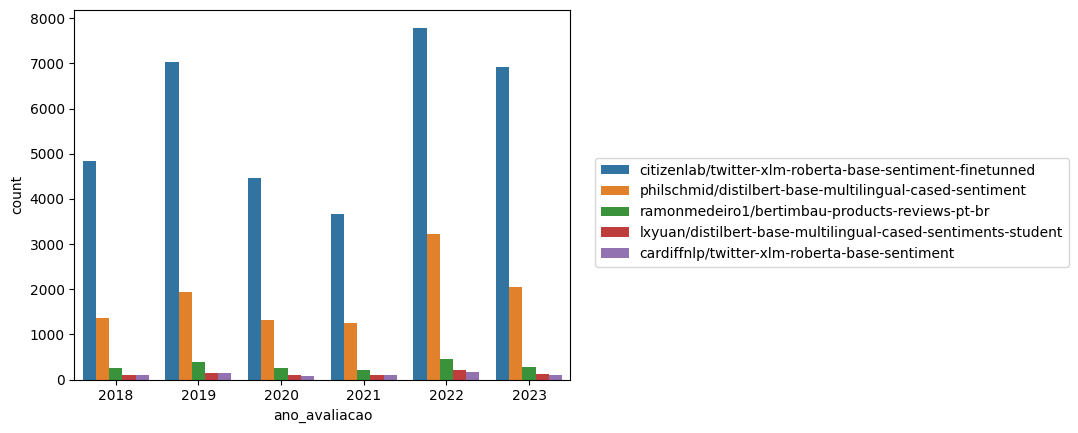

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='ano_avaliacao',
              hue='sentiment_bert_max',
              data=teste)
plt.legend(bbox_to_anchor=(1.05, .6), loc='upper left', borderaxespad=0)

In [ ]:
import seaborn as sns

sns.relplot(x='ano_avaliacao', y='sentiment_score', kind="line", hue='sentiment_label', data=teste)

In [ ]:
sns.relplot(x='ano_avaliacao', y='sentiment_score_2', kind="line", hue='sentiment_label_2', data=teste)

ValueError: ignored

<Axes: xlabel='ano_avaliacao', ylabel='count'>

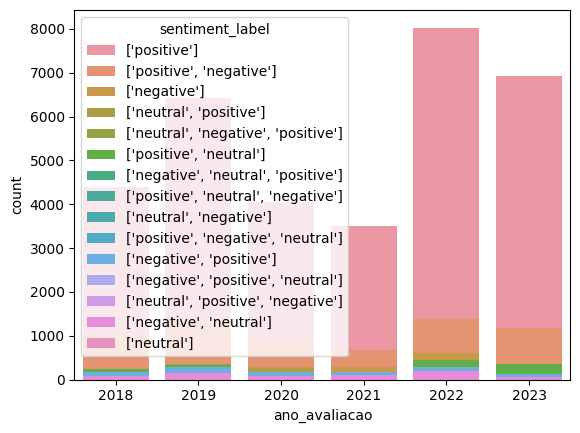

In [ ]:
sns.countplot(x='ano_avaliacao',
              hue='sentiment_label',
              data=teste,
              dodge=False)

In [ ]:
sns.countplot(x='ano_avaliacao',
              hue='sentiment_label_2',
              data=teste)

In [ ]:
sns.relplot(x='ano_avaliacao', col_wrap=3, col="source", y='sentiment_score', hue='sentiment_label', data=teste, kind='line')

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f577bad2cb0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f577bad1f30> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
teste[(teste.sentiment_label != teste.sentiment_label_2)][['text','sentiment_label', 'sentiment_score']]

In [ ]:
sns.relplot(x='ano_avaliacao', y='sentiment_score_2', kind="line", hue='sentiment_label_2', data=teste[(teste.sentiment_label != teste.sentiment_label_2)], palette='Set2')
sns.relplot(x='ano_avaliacao', y='sentiment_score', kind="line", hue='sentiment_label', data=teste[(teste.sentiment_label != teste.sentiment_label_2)], palette='Set2')

In [ ]:
sns.scatterplot(data=teste[(teste.sentiment_label != teste.sentiment_label_2) & (abs(teste.sentiment_score - teste.sentiment_score_2) > 0.00)], x="sentiment_score", y="sentiment_score_2")

In [ ]:
teste[(teste.sentiment_label != teste.sentiment_label_2) & (abs(teste.sentiment_score - teste.sentiment_score_2) > 0.00)].sample()

AttributeError: ignored

In [ ]:
import ast

ast.literal_eval(teste['sentiment_label'][0])

['positive']

In [ ]:
teste[teste['sentiment_label'].apply(lambda x: len(ast.literal_eval(x)) == 1)][['sentiment_label', 'text', 'sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4','sentiment_bert_5']]

,sentiment_label,text,sentiment_bert_1,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5
0,['positive'],"Lugar fantástico, recomendo super.","{'label': 'positive', 'score': 0.9849022030830...","{'label': 'positive', 'score': 0.9592684507369...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'Positive', 'score': 0.9925462603569..."
2,['positive'],excelente!,"{'label': 'positive', 'score': 0.9857670068740...","{'label': 'positive', 'score': 0.9891675710678...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'Positive', 'score': 0.9923394918441..."
3,['positive'],Belo lugar.,"{'label': 'positive', 'score': 0.8551892638206...","{'label': 'positive', 'score': 0.781340479850769}","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'Positive', 'score': 0.9930474162101..."
4,['positive'],Ótimo local,"{'label': 'positive', 'score': 0.8495931029319...","{'label': 'positive', 'score': 0.5628671050071...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'Positive', 'score': 0.9923906922340..."
5,['positive'],excelente local otima vista e hospitalidade pe...,"{'label': 'positive', 'score': 0.9734945893287...","{'label': 'positive', 'score': 0.9737055897712...","{'label': 'Positive', 'score': 0.988045871257782}","{'label': 'Positive', 'score': 0.988045871257782}","{'label': 'Positive', 'score': 0.988045871257782}"
...,...,...,...,...,...,...,...
49213,['positive'],Simplesmente amei,"{'label': 'positive', 'score': 0.727571427822113}","{'label': 'positive', 'score': 0.608471155166626}","{'label': 'Positive', 'score': 0.9922024011611...","{'label': 'Positive', 'score': 0.9922024011611...","{'label': 'Positive', 'score': 0.9922024011611..."
49215,['positive'],Um sonho,"{'label': 'positive', 'score': 0.5642338991165...","{'label': 'positive', 'score': 0.5150464177131...","{'label': 'Positive', 'score': 0.7321606874465...","{'label': 'Positive', 'score': 0.7321606874465...","{'label': 'Positive', 'score': 0.7321606874465..."
49216,['positive'],Excelente Resort,"{'label': 'positive', 'score': 0.987581729888916}","{'label': 'positive', 'score': 0.9462223052978...","{'label': 'Positive', 'score': 0.9921082854270...","{'label': 'Positive', 'score': 0.9921082854270...","{'label': 'Positive', 'score': 0.9921082854270..."
49217,['positive'],Lugar lindo! Ótimo para descansar.,"{'label': 'positive', 'score': 0.9002830386161...","{'label': 'positive', 'score': 0.6816404461860...","{'label': 'Positive', 'score': 0.9932357668876...","{'label': 'Positive', 'score': 0.9932357668876...","{'label': 'Positive', 'score': 0.9932357668876..."


In [ ]:
teste[teste['sentiment_label'].apply(lambda x: len(ast.literal_eval(x)) == 2)][['sentiment_label', 'text', 'sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4','sentiment_bert_5']]

,sentiment_label,text,sentiment_bert_1,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5
1,"['positive', 'negative']",Tudo perfeito,"{'label': 'positive', 'score': 0.9701986312866...","{'label': 'negative', 'score': 0.6602097153663...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'Positive', 'score': 0.9922283291816..."
17,"['neutral', 'positive']","Quadra, piscina, praça e ao lado da praia sem ...","{'label': 'neutral', 'score': 0.5129052996635437}","{'label': 'positive', 'score': 0.5697891712188...","{'label': 'Neutral', 'score': 0.6083300113677979}","{'label': 'Neutral', 'score': 0.6083300113677979}","{'label': 'Neutral', 'score': 0.6083300113677979}"
19,"['positive', 'negative']",É um ótimo hotel para levar a família e curtir...,"{'label': 'positive', 'score': 0.9578593969345...","{'label': 'negative', 'score': 0.5199328660964...","{'label': 'Positive', 'score': 0.9722692966461...","{'label': 'Positive', 'score': 0.9722692966461...","{'label': 'Positive', 'score': 0.9722692966461..."
22,"['neutral', 'positive']",Atendimento e alimentação.,"{'label': 'positive', 'score': 0.8624117374420...","{'label': 'positive', 'score': 0.7141097187995...","{'label': 'Neutral', 'score': 0.9898031949996948}","{'label': 'Neutral', 'score': 0.9898031949996948}","{'label': 'Neutral', 'score': 0.9898031949996948}"
28,"['positive', 'negative']","Aconchegante, bem localizado e com ótimo servi...","{'label': 'negative', 'score': 0.70010906457901}","{'label': 'positive', 'score': 0.7468746900558...","{'label': 'Positive', 'score': 0.9913169145584...","{'label': 'Positive', 'score': 0.9913169145584...","{'label': 'Positive', 'score': 0.9913169145584..."
...,...,...,...,...,...,...,...
49199,"['neutral', 'positive']",Melhorar muito a infraestrutura.,"{'label': 'positive', 'score': 0.818744421005249}","{'label': 'positive', 'score': 0.8409448266029...","{'label': 'Neutral', 'score': 0.9386424422264099}","{'label': 'Neutral', 'score': 0.9386424422264099}","{'label': 'Neutral', 'score': 0.9386424422264099}"
49200,"['positive', 'negative']",Pelo atenção e atendimento em todos os sentido...,"{'label': 'positive', 'score': 0.9378687739372...","{'label': 'negative', 'score': 0.5224962830543...","{'label': 'Positive', 'score': 0.9896613359451...","{'label': 'Positive', 'score': 0.9896613359451...","{'label': 'Positive', 'score': 0.9896613359451..."
49201,"['positive', 'negative']",Tudo de bom,"{'label': 'negative', 'score': 0.6747020483016...","{'label': 'negative', 'score': 0.7172132730484...","{'label': 'Positive', 'score': 0.9868878722190...","{'label': 'Positive', 'score': 0.9868878722190...","{'label': 'Positive', 'score': 0.9868878722190..."
49206,"['neutral', 'positive']",Tudo,"{'label': 'positive', 'score': 0.8212609887123...","{'label': 'positive', 'score': 0.4054795801639...","{'label': 'Neutral', 'score': 0.913355827331543}","{'label': 'Neutral', 'score': 0.913355827331543}","{'label': 'Neutral', 'score': 0.913355827331543}"


In [ ]:
teste[teste['sentiment_label'].apply(lambda x: len(ast.literal_eval(x)) > 2)][['sentiment_label', 'rating', 'text', 'sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4','sentiment_bert_5']]

,sentiment_label,rating,text,sentiment_bert_1,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5
20,"['neutral', 'negative', 'positive']",3.0,"O hotel é limpo, os funcionários muito educado...","{'label': 'neutral', 'score': 0.725369930267334}","{'label': 'positive', 'score': 0.507336437702179}","{'label': 'Negative', 'score': 0.5601344108581...","{'label': 'Negative', 'score': 0.5601344108581...","{'label': 'Negative', 'score': 0.5601344108581..."
39,"['negative', 'neutral', 'positive']",5.0,Sem palavras,"{'label': 'positive', 'score': 0.3510648608207...","{'label': 'neutral', 'score': 0.4789133667945862}","{'label': 'Negative', 'score': 0.7170167565345...","{'label': 'Negative', 'score': 0.7170167565345...","{'label': 'Negative', 'score': 0.7170167565345..."
57,"['positive', 'neutral', 'negative']",5.0,Lugar incrível,"{'label': 'neutral', 'score': 0.510798990726471}","{'label': 'negative', 'score': 0.4616160988807...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952..."
130,"['positive', 'neutral', 'negative']",5.0,Lugar incrível,"{'label': 'neutral', 'score': 0.510798990726471}","{'label': 'negative', 'score': 0.4616160988807...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952..."
132,"['positive', 'negative', 'neutral']",3.0,"Difícil dizer,por que amo praia e é um lugar q...","{'label': 'neutral', 'score': 0.45937931537628...","{'label': 'negative', 'score': 0.4774778187274...","{'label': 'Positive', 'score': 0.9845324158668...","{'label': 'Positive', 'score': 0.9845324158668...","{'label': 'Positive', 'score': 0.9845324158668..."
...,...,...,...,...,...,...,...,...
48937,"['positive', 'negative', 'neutral']",5.0,"Camarim Grande é maravilhoso, sendo que infeli...","{'label': 'neutral', 'score': 0.41920384764671...","{'label': 'positive', 'score': 0.7904974818229...","{'label': 'Negative', 'score': 0.714795708656311}","{'label': 'Negative', 'score': 0.714795708656311}","{'label': 'Negative', 'score': 0.714795708656311}"
48961,"['neutral', 'positive', 'negative']",4.0,Lugar para se deixar as pernas voltadas para o...,"{'label': 'positive', 'score': 0.7103403210639...","{'label': 'negative', 'score': 0.4030974209308...","{'label': 'Neutral', 'score': 0.975810170173645}","{'label': 'Neutral', 'score': 0.975810170173645}","{'label': 'Neutral', 'score': 0.975810170173645}"
49096,"['neutral', 'positive', 'negative']",5.0,Conheci pela primeira vez o pecado da gula. Po...,"{'label': 'positive', 'score': 0.8575298190116...","{'label': 'negative', 'score': 0.6595584154129...","{'label': 'Neutral', 'score': 0.9615657329559326}","{'label': 'Neutral', 'score': 0.9615657329559326}","{'label': 'Neutral', 'score': 0.9615657329559326}"
49140,"['neutral', 'negative', 'positive']",4.0,"Passamos só 4 dias no Salinas, pois era só o q...","{'label': 'negative', 'score': 0.9009762406349...","{'label': 'positive', 'score': 0.5664177536964...","{'label': 'Neutral', 'score': 0.9686949849128723}","{'label': 'Neutral', 'score': 0.9686949849128723}","{'label': 'Neutral', 'score': 0.9686949849128723}"


In [ ]:
treinado[treinado.text == 'Sem palavras'][['relative_date', 'likes', 'mes_ano_avaliacao', 'analisar', 'sentiment_bert', 'rating', 'text', 'source']]

,relative_date,likes,user_is_local_guide,mes_ano_avaliacao,analisar,sentiment_bert,rating,text,source
39,3 semanas atrás,0,False,2023-06,True,neutral,5.0,Sem palavras,analisar
7025,2 semanas atrás,0,False,2023-06,True,neutral,5.0,Sem palavras,analisar
14824,4 anos atrás,0,True,2019-07,True,neutral,5.0,Sem palavras,analisar
24048,5 anos atrás,0,True,2018-07,True,neutral,5.0,Sem palavras,analisar
28383,5 anos atrás,0,True,2018-07,True,neutral,5.0,Sem palavras,analisar
39693,4 anos atrás,1,False,2019-07,True,neutral,5.0,Sem palavras,analisar
40325,5 anos atrás,0,False,2018-07,True,neutral,5.0,Sem palavras,analisar


In [ ]:
teste[teste.text == 'Sem palavras'][['relative_date', 'likes', 'mes_ano_avaliacao', 'analisar', 'sentiment_bert', 'rating', 'text', 'source']]

,relative_date,likes,mes_ano_avaliacao,analisar,sentiment_bert,rating,text,source
39,3 semanas atrás,0,2023-06,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,hotel-marsol-beach-resort
5932,5 anos atrás,0,2018-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,salinas-maceió-all-inclusive-resort
14076,5 anos atrás,0,2018-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,la-torre-resort-all-inclusive
14548,2 semanas atrás,0,2023-06,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,hotel-vila-galé---touros
35522,4 anos atrás,0,2019-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,hotel-vila-galé-marés
48076,4 anos atrás,1,2019-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,salinas-maragogi-all-inclusive-resort
48708,5 anos atrás,0,2018-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,salinas-maragogi-all-inclusive-resort


precisa de finetuning?

https://huggingface.co/transformers/v3.5.1/custom_datasets.html

# bert

https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

https://sol.sbc.org.br/index.php/stil/article/view/17784

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [ ]:
teste['sentiment_label'][0]

"['positive']"